# Thall et al 2003

**Hierarchical Bayesian approaches to phase II trials in diseases with multiple subtypes**

Some important excerpts

![](2022-06-21-11-48-03.png)

![](2022-06-21-11-18-30.png)

![](2022-06-21-11-46-54.png)

![](2022-06-22-12-15-57.png)

In [1]:
import sys

sys.path.append("../imprint/research/berry/")
import berrylib.util as util

util.setup_nb()


In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config

# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)


/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checking the distributions are correct.

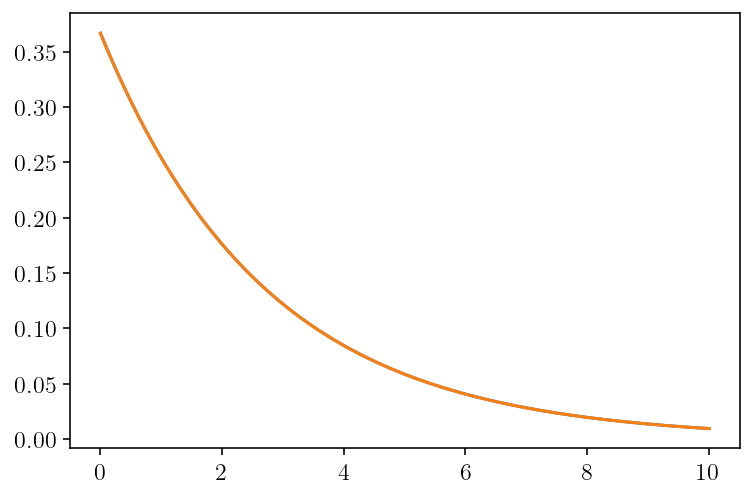

In [3]:
# Equivalence of scipy's exponential distribution and gamma distribution.
plt_vs = np.linspace(0.01, 10, 1000)
L = 1.0
rho = 1.0
mu_ttf = L * np.exp(rho)
hazard = 1.0 / mu_ttf
epdf = scipy.stats.expon.pdf(plt_vs, scale=mu_ttf)
gpdf = scipy.stats.gamma.pdf(plt_vs, 1.0, scale=mu_ttf)
plt.plot(plt_vs, epdf)
plt.plot(plt_vs, gpdf)
plt.show()


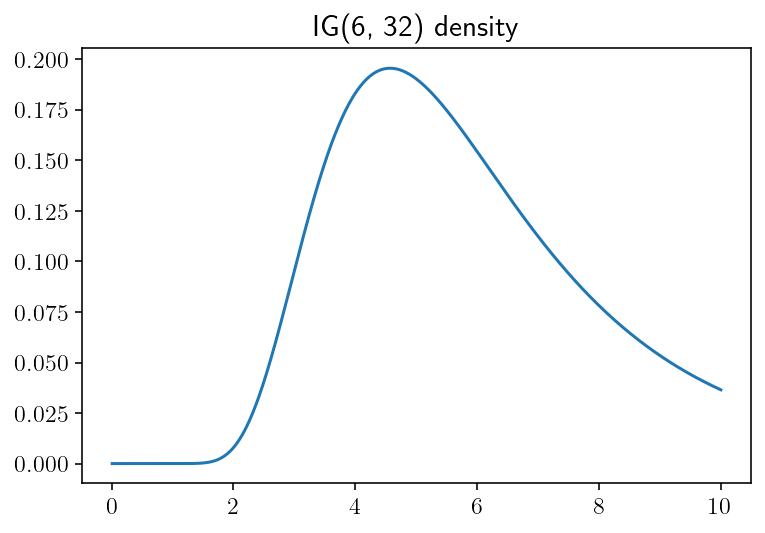

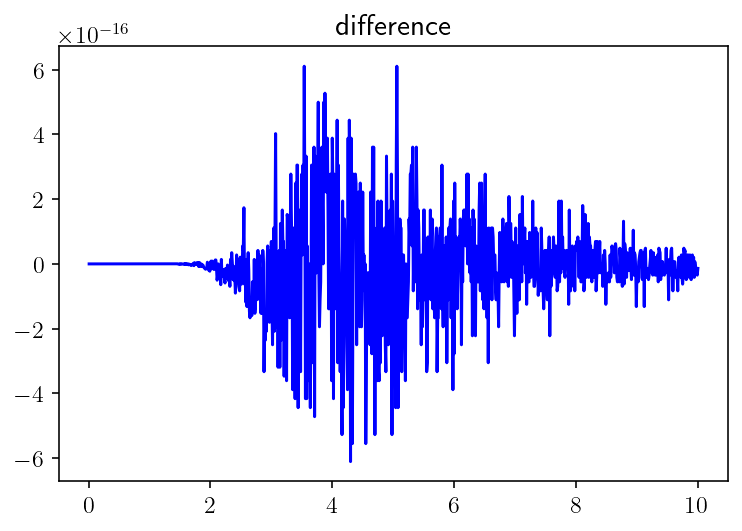

In [4]:
# Establishing the equivalence of scipy's invgamma and gamma pdfs.
alpha = 6
beta = 32
invgamma = scipy.stats.invgamma.pdf(plt_vs, alpha, scale=beta)
trans_gamma = scipy.stats.gamma.pdf(1.0 / plt_vs, alpha, scale=1.0 / beta) / (
    plt_vs**2
)
plt.title(f"IG({alpha}, {beta}) density")
plt.plot(plt_vs, invgamma)
plt.show()
plt.title("difference")
plt.plot(plt_vs, trans_gamma - invgamma, "b-")
plt.show()


## Setting up priors

mean, 95% ci
18.10, [12.06271817 27.07245591]
 5.09, [3.99527636 6.48455131]
 6.00, [4.38906768 8.18852176]


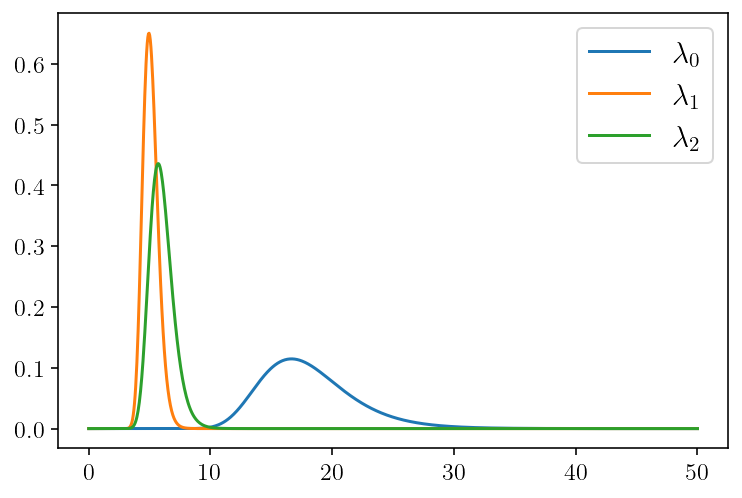

In [5]:
# Priors on lambda_j
# Check that they have the same mean and 95% CI as described in Table II of the paper.
alpha = [24, 66, 40]
beta = [416.3, 331, 234]
plt_vs = np.linspace(0, 50, 1000)
print("mean, 95% ci")
for j in range(3):
    pdf = scipy.stats.invgamma.pdf(plt_vs, alpha[j], scale=beta[j])
    plt.plot(plt_vs, pdf, label=f"$\lambda_{j}$")
    plt_vs = np.linspace(0, 50, 1000)
    mean = scipy.stats.invgamma.mean(alpha[j], scale=beta[j])
    ci = scipy.stats.invgamma.ppf([0.025, 0.975], alpha[j], scale=beta[j])
    print(f"{mean:5.2f}, {ci}")
plt.legend()
plt.show()


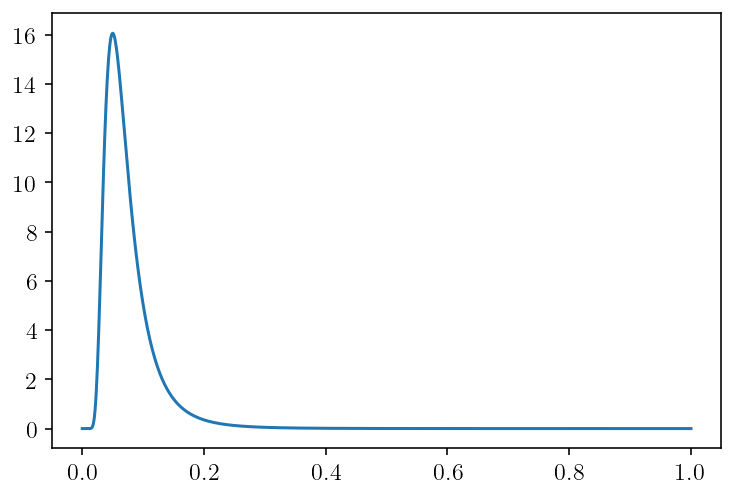

In [6]:
# Priors on rho_j
# mu_mean = 0.1856
# mu_sig2 = 1.0 / 0.5
# sig2_alpha = 3.0
# sig2_beta = 3.0
mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
sig2_dist = scipy.stats.invgamma(sig2_alpha, scale=sig2_beta)

plt_vs = np.linspace(0, 1, 1000)
pdf = sig2_dist.pdf(plt_vs)
plt.plot(plt_vs, pdf)
plt.show()


In [7]:
# What is the support of the prior? (Much nicer than the Berry prior!)
sig2_dist.ppf([0.0000001, 0.999, 0.99999])


array([0.01147018, 0.40574989, 1.10057506])

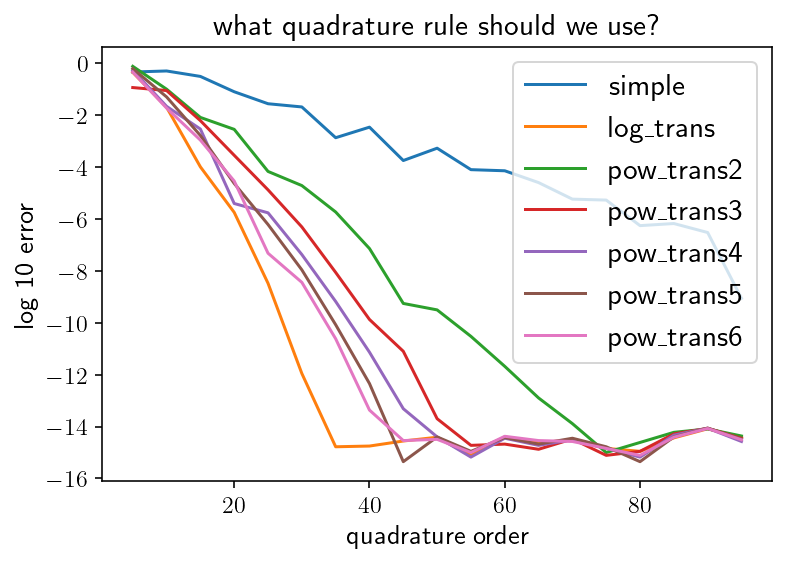

In [8]:
left = sig2_dist.ppf(1e-6) / 2
left_quantile = sig2_dist.cdf(left)
right_quantile = 1.0 - 1e-7
right = sig2_dist.ppf(right_quantile)
true_integral = right_quantile - left_quantile


def pow_gauss_rule(N, a, b, pow):
    A = (a) ** (1.0 / pow)
    B = (b) ** (1.0 / pow)
    qr = util.gauss_rule(N, a=A, b=B)
    pts = qr.pts**pow
    wts = pow * qr.pts ** (pow - 1) * qr.wts
    return util.QuadRule(pts, wts)


rules = dict(
    simple=util.gauss_rule,
    log_trans=util.log_gauss_rule,
)
for pow in [2, 3, 4, 5, 6]:
    rules[f"pow_trans{pow}"] = lambda N, a, b, pow=pow: pow_gauss_rule(N, a, b, pow)
orders = np.arange(5, 100, 5)
err = {k: [] for k in rules}
for i in orders:
    for k in rules:
        qr = rules[k](i, left, right)
        pdf = sig2_dist.pdf(qr.pts)
        quad = np.sum(pdf * qr.wts)
        err[k].append(quad - true_integral)

for k in rules:
    plt.plot(orders, np.log10(np.abs(err[k])), label=k)
plt.legend()
plt.title("what quadrature rule should we use?")
plt.ylabel("log 10 error")
plt.xlabel("quadrature order")
plt.show()


In [9]:
# 15 points with the log transformation should probably be good enough but we might consider 20 points.
orders[2], err["log_trans"][2], orders[3], err["log_trans"][3]


(15, -0.0001019743172334664, 20, 1.7947902204440425e-06)

In [40]:
20, left, right

(20, 0.006401632420120484, 2.8421994410275007)

In [10]:
qr_sigma2 = util.log_gauss_rule(20, left, right)

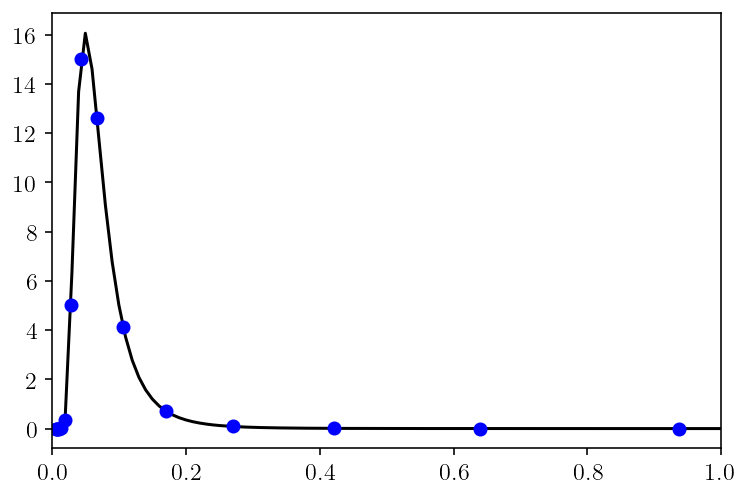

In [11]:
# But the distribution of points is still pretty obviously suboptimal, with too
# many points out in the two tails and too few points in the steep area.
plt_vs = np.linspace(0, 10, 1000)
pdf = sig2_dist.pdf(plt_vs)
plt.plot(plt_vs, pdf, "k")
plt.plot(qr_sigma2.pts, sig2_dist.pdf(qr_sigma2.pts), "bo")
plt.xlim([0, 1])
plt.show()


**I could design optimal quadrature rule for the known prior?!**

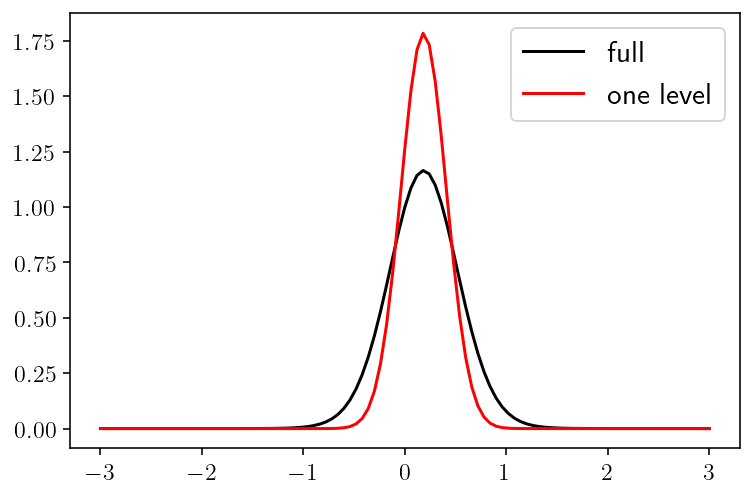

In [12]:
rho_range = [-3, 3]
mu_qr = util.simpson_rule(101, *rho_range)
mu_vs = mu_qr.pts
rho_sig2_pdf = scipy.stats.norm.pdf(
    mu_vs[:, None], mu_mean, np.sqrt(mu_sig2 + qr_sigma2.pts[None, :])
)
rho_pdf = np.sum(
    rho_sig2_pdf * (sig2_dist.pdf(qr_sigma2.pts) * qr_sigma2.wts)[None], axis=1
)
rho_pdf2 = scipy.stats.norm.pdf(mu_vs, mu_mean, np.sqrt(mu_sig2))
plt.plot(mu_vs, rho_pdf, "k-", label="full")
plt.plot(mu_vs, rho_pdf2, "r-", label="one level")
plt.legend()
plt.show()


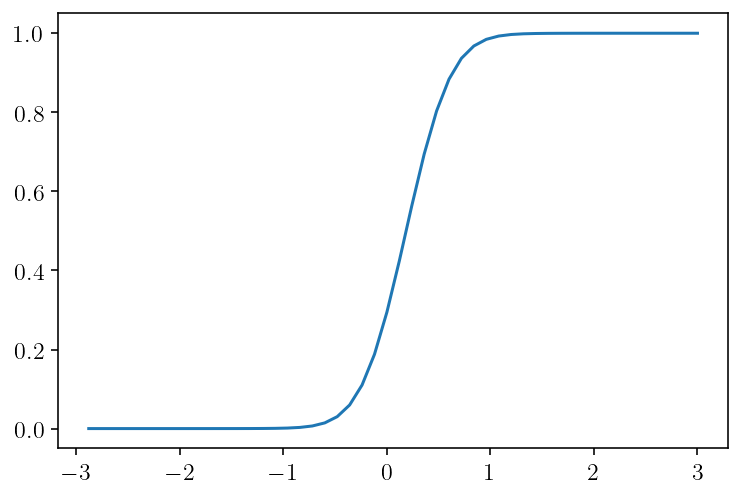

In [13]:
cdf = []
for i in range(3, mu_qr.pts.shape[0] + 1, 2):
    cdf_wts = util.simpson_rule(i, rho_range[0], mu_qr.pts[i - 1]).wts
    cdf.append((rho_pdf[:i] * cdf_wts).sum())
cdf = np.array(cdf)
cdf_pts = mu_qr.pts[2::2]
plt.plot(cdf_pts, cdf)
plt.show()


In [14]:
np.exp(cdf_pts[np.argmin(cdf < 0.025)]), np.exp(cdf_pts[np.argmax(cdf > 0.975)])


(0.6187833918061408, 2.611696473423118)

In [15]:
# check that the quadrature rule is working correctly.
correct = np.sin(rho_range[1]) - np.sin(rho_range[0])
test = (np.cos(mu_vs) * mu_qr.wts).sum()
test - correct, test

(2.032999385503942e-08, 0.2822400364497283)

In [16]:
(rho_pdf * np.exp(mu_vs) * mu_qr.wts).sum()


1.2818893143294785

In [17]:
(mu_vs * rho_pdf * mu_qr.wts).sum()


0.18559961576261566

In [18]:
mu_mean, mu_sig2


(0.1856, 0.05)

There's some bad stuff going on with these priors:
* in the paper they state that $E(\exp(\rho_j)) = 1.25$. This is absolutely not true for the parameters provided in the WinBUGS appendix.
* in fact, that expectation does not converge for the parameters provided.

To deal with this, I re-tuned the hyperparameters using the suggestions given:
* $E(\exp(\rho_j)) = 1.25$
* $E(\exp(\rho_2) | \exp(\rho_1) = 1.5) = 1.275$

Below, we approximately demonstrate these suggestions. The match is not precise, but neither is sampling.

In [19]:
mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
sig2_dist = scipy.stats.invgamma(sig2_alpha, scale=sig2_beta)
print(sig2_dist.mean(), sig2_dist.var())

0.075 0.0018749999999999997


In [20]:
def sample():
    mu = numpyro.sample("mu", dist.Normal(mu_mean, jnp.sqrt(mu_sig2)))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(sig2_alpha, sig2_beta))
    # numpyro.sample("rho", dist.Normal(mu, jnp.sqrt(sigma2)))
    # with numpyro.plate("j", 3):
    #     numpyro.sample(f"rho", dist.Normal(mu, jnp.sqrt(sigma2)))
    rhos = []
    for j in range(3):
        rhos.append(numpyro.sample(f"rho{j}", dist.Normal(mu, jnp.sqrt(sigma2))))
    # tau = numpyro.sample("tau", dist.Gamma(sig2_alpha, sig2_beta))
    # numpyro.sample("rho", dist.Normal(mu, jnp.sqrt(1.0 / tau)))


seed = 10
n_samples = 100000
nuts_kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(seed)
mcmc.run(rng_key)
samples = mcmc.get_samples()

print("E(e^rho) = ", np.sum(np.exp(samples["rho0"]), axis=0) / n_samples)


E(e^rho) =  1.2781669409954448


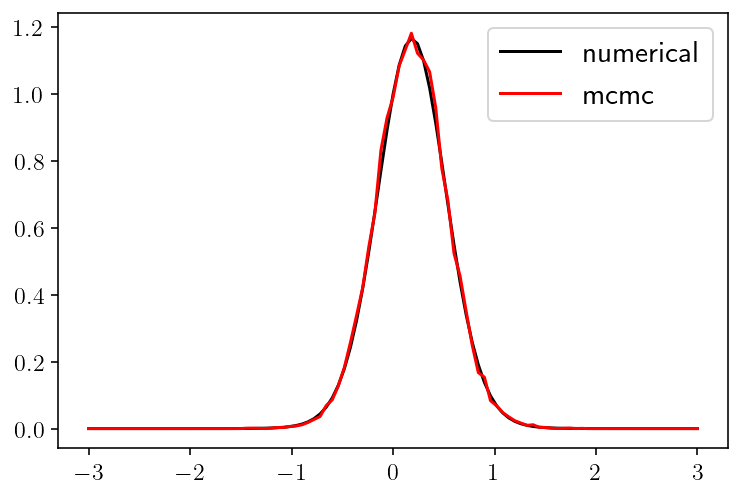

In [21]:
rho_kde = scipy.stats.gaussian_kde(samples["rho0"].to_py(), bw_method=0.01)(mu_qr.pts)
plt.plot(mu_qr.pts, rho_pdf, "k-", label="numerical")
plt.plot(mu_qr.pts, rho_kde, "r-", label="mcmc")
plt.legend()
plt.show()


In [22]:
ci025 = np.log(0.65)
ci975 = np.log(2.20)
np.mean(samples["rho0"] < ci025), np.mean(samples["rho0"] > ci975)


(DeviceArray(0.04021, dtype=float64), DeviceArray(0.04188, dtype=float64))

In [23]:
sample_conditional = numpyro.handlers.condition(sample, {"rho0": np.log(1.5)})
nuts_kernel = numpyro.infer.NUTS(sample_conditional)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(seed)
mcmc.run(rng_key)
samples = mcmc.get_samples()

print(
    "E(e^rho_1 | e^rho_0 = 1.5) = ",
    np.exp(samples["rho1"].mean()),
    np.exp(samples["rho2"].mean()),
)


E(e^rho_1 | e^rho_0 = 1.5) =  1.3198780130544425 1.3264187485325898


## Simulating the trial

For now, I'm going to fix the values of $\lambda_j$ to simplify the design and extract the basic basket trial aspect.

In [44]:
import sys

sys.path.append("../imprint/research/berry/")
import berrylib.util as util

util.setup_nb()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config

# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)


In [46]:
mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
alpha = [24, 66, 40]
beta = [416.3, 331, 234]

narms = 3
accrual_time = 24
npatients = 24 * 4
monitor_time = 12
total_time = accrual_time + monitor_time

accrual_rates = np.array([1, 2, 1])

accrual_prob = accrual_rates / accrual_rates.sum()

lambdaj = scipy.stats.invgamma.mean(alpha, scale=beta)


def simulate(ntrials, seed=None):
    if seed is not None:
        np.random.seed(seed)

    mu = scipy.stats.norm.rvs(mu_mean, np.sqrt(mu_sig2), size=ntrials)
    sig2 = scipy.stats.invgamma.rvs(sig2_alpha, scale=sig2_beta, size=ntrials)
    rho = scipy.stats.norm.rvs(
        mu[:, None], np.sqrt(sig2)[:, None], size=(ntrials, narms)
    )
    return simulate_known_rho(rho)


def simulate_known_rho(rho, seed=None):
    ntrials = rho.shape[0]
    if seed is not None:
        np.random.seed(seed)

    arm_multinomial = scipy.stats.multinomial.rvs(
        1, accrual_prob, size=(ntrials, npatients)
    )
    # arm_multinomial is (ntrials, npatients, narms)
    # arm_assignments is (ntrials, npatients) where the integer value indicates the arm assignment.
    arm_assignments = np.where(arm_multinomial)[2].reshape((ntrials, npatients))

    trial_index_per_patient = np.tile(np.arange(ntrials)[:, None], (1, npatients))
    rho_arm = rho[trial_index_per_patient, arm_assignments]
    lambda_arm = lambdaj[arm_assignments]
    # time to failure, aka 1/hazard
    time_to_failure = np.exp(rho_arm) * lambda_arm
    event_time = scipy.stats.expon.rvs(scale=time_to_failure)
    arrival_time = np.tile(
        np.linspace(0, accrual_time, npatients)[None, :], (ntrials, 1)
    )
    is_censored = np.where(event_time + arrival_time > total_time, True, False)
    censored_event_time = np.where(is_censored, total_time - arrival_time, event_time)
    return time_to_failure, arrival_time, is_censored, censored_event_time, arm_assignments


ntrials = 5000
rho = np.zeros((ntrials, narms))
true_ttf, arrival_time, is_censored, event_time, arm_assignments = simulate_known_rho(rho, seed=None)
for arm_idx in range(3):
    print(arm_idx, event_time[arm_assignments == arm_idx].mean(), lambdaj[arm_idx])


0 12.912760496162262 18.1
1 4.978454049704113 5.092307692307693
2 5.783361453147088 6.0


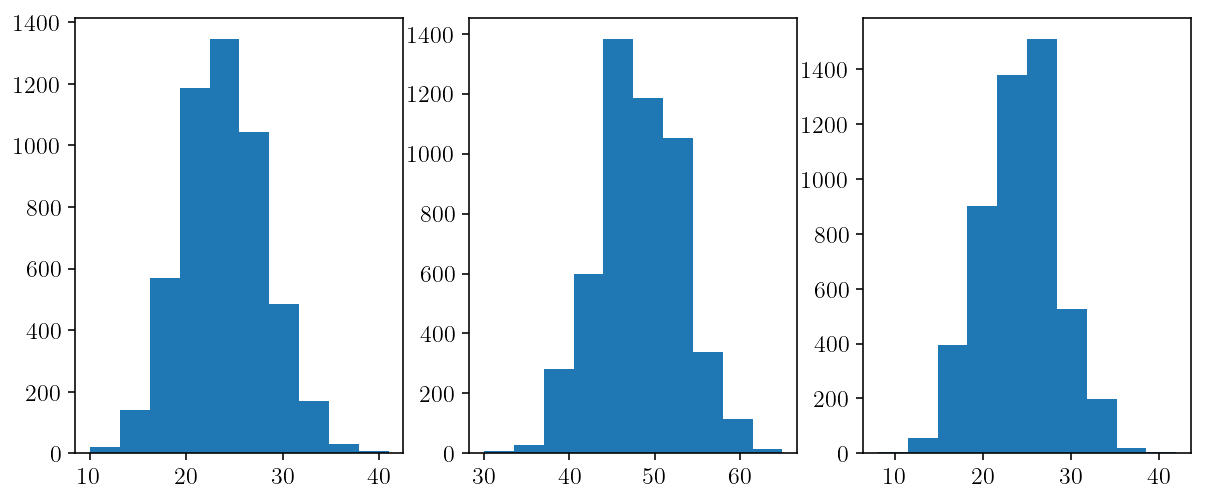

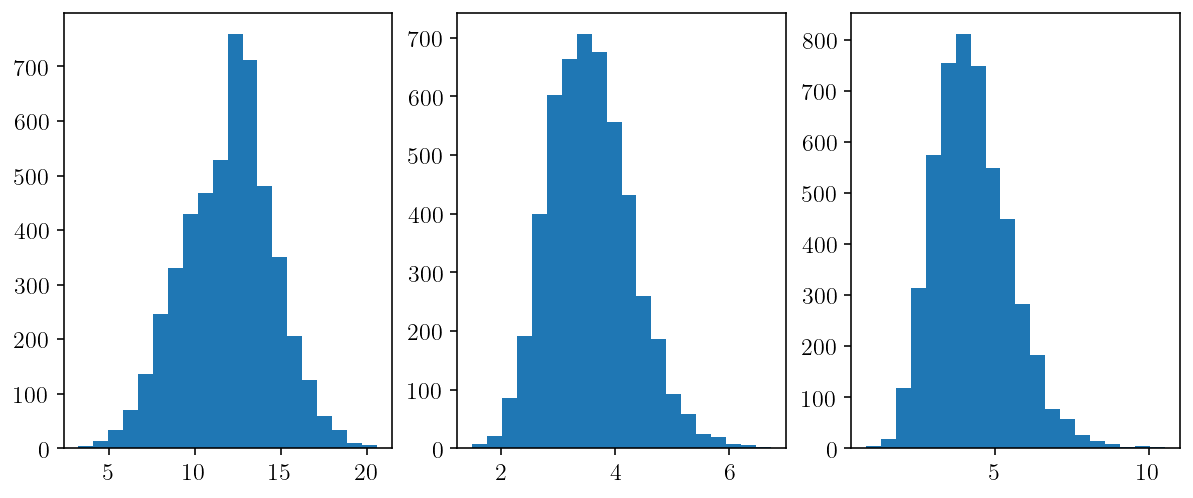

In [47]:
# simulate under the null that the treatment has no effect. the time to failure
# multiplier is np.exp(rho), so rho = 0 results in a failure multiplier of 1.0
# leading to hazard equal to that under past treatment.
null_rho = np.tile(np.array([0.0, 0.0, 0.0])[None, :], (ntrials, 1))

true_hazard, arrival_time, is_censored, event_time, arm_assignments = simulate_known_rho(null_rho)
median_event_times = np.empty((ntrials, narms))
npatients_per_arm = np.empty((ntrials, narms), dtype=int)
for i in range(ntrials):
    for arm_idx in range(3):
        median_event_times[i, arm_idx] = np.median(event_time[i, arm_assignments[i,:] == arm_idx])
        npatients_per_arm[i, arm_idx] = np.sum(arm_assignments[i,:] == arm_idx)
plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,1 + i)
    plt.hist(npatients_per_arm[:,i])
plt.show()
plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,1 + i)
    plt.hist(median_event_times[:,i], bins=20)
plt.show()

Event time quantiles are lower than the expected time to event because they are censored.

In [48]:
for j in range(3):
    print(lambdaj[j], np.quantile(median_event_times[:,j], [0.25, 0.5, 0.75]))

18.1 [10.13849297 12.18077896 13.65670363]
5.092307692307693 [3.04259582 3.50961863 4.02345894]
6.0 [3.41008866 4.16322336 5.0478452 ]


In [49]:
event_time.shape

(5000, 96)

In [50]:
def construct_suff_stats(is_censored, event_time, arm_assignments):
    n_events = np.empty((ntrials, narms))
    total_obs_time = np.empty((ntrials, narms))
    for i in range(ntrials):
        for j in range(narms):
            this_arm = arm_assignments[i, :] == j
            n_events[i,j] = np.sum(np.where(~is_censored[i, this_arm], 1, 0))
            total_obs_time[i,j] = np.sum(event_time[i, this_arm])
    return np.stack((n_events, total_obs_time), axis=-1)

suff_stats = construct_suff_stats(is_censored, event_time, arm_assignments)

In [51]:
class CensoredExponential(dist.Distribution):
    def __init__(self, hazard, validate_args=None):
        self.hazard = hazard
        self.log_hazard = jnp.log(hazard)
        super(CensoredExponential, self).__init__(
            batch_shape=jnp.shape(hazard), validate_args=validate_args
        )

    def sample(self, key):
        raise NotImplementedError()

    def log_prob(self, suff_stats):
        n_events, total_obs_time = suff_stats
        return self.log_hazard * n_events - self.hazard * total_obs_time

def sample(suff_stats):
    mu = numpyro.sample("mu", dist.Normal(mu_mean, mu_sig2))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(sig2_alpha, sig2_beta))
    for j in range(narms):
        rhoj = numpyro.sample(f"rho{j}", dist.Normal(mu, jnp.sqrt(sigma2)))
        numpyro.sample(
            f"x{j}",
            CensoredExponential(1.0 / (jnp.exp(rhoj) * lambdaj[j])),
            obs=suff_stats[j],
        )

In [52]:
n_samples = 100000
kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(10)

In [188]:
def mcmc_run(mcmc, suff_stats):
    mcmc.run(rng_key, suff_stats)
    samples = mcmc.get_samples()
    rho_samples = np.empty((n_samples, narms))
    for j in range(3):
        rho_samples[:, j] = samples[f'rho{j}']
    return samples, rho_samples

In [54]:
# stop = 0
# risky = 0
# for i in range(100):
#     mcmc_run(suff_stats[i])
#     prob_erho_above = np.sum(np.exp(rho_samples) > 1.5, axis=0) / n_samples
#     if np.all(prob_erho_above < 0.075):
#         stop += 1
#     if np.any(prob_erho_above > 0.5):
#         risky += 1
# print(stop, risky)

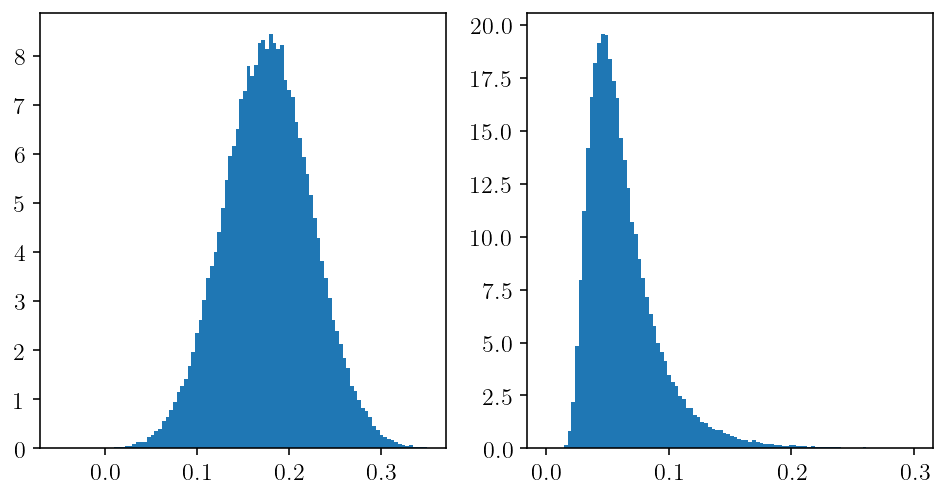

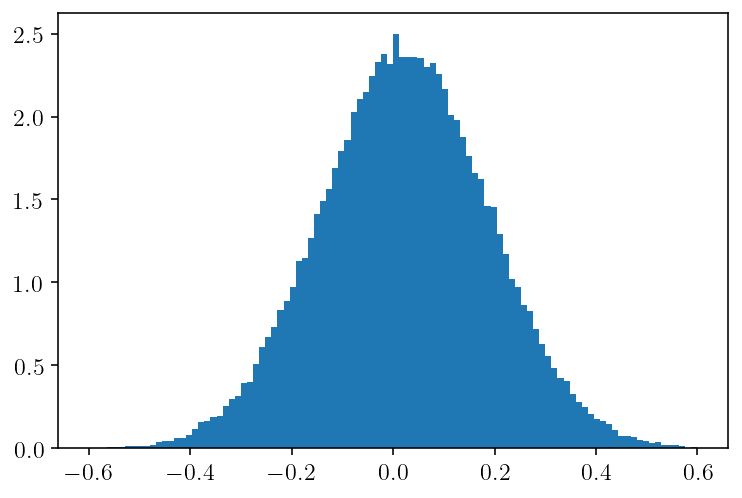

(DeviceArray(0.17679911, dtype=float64),
 DeviceArray(0.06370793, dtype=float64),
 array([0.02341892, 0.10658219, 0.19816329]))

In [66]:
samples, rho_samples = mcmc_run(suff_stats[0])
mu_samples = samples['mu']
sig2_samples = samples['sigma2']
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=np.linspace(-0.05, 0.35, 101), density=True)
plt.subplot(1, 2, 2)
plt.hist(sig2_samples, bins=np.linspace(0, 0.3, 101), density=True)
plt.show()
plt.hist(rho_samples[:,0], density=True, bins=np.linspace(-0.6, 0.6, 101))
plt.show()
mu_samples.mean(), sig2_samples.mean(), rho_samples.mean(axis=0)

In [185]:
sigma2_rule.pts[-1]

2.7832934704550967

In [189]:
sample_fixed_sigma2 = numpyro.handlers.condition(sample, dict(sigma2=2.7832934704550967))
n_samples = 100000
kernel = numpyro.infer.NUTS(sample_fixed_sigma2)
mcmc_fixed_sigma2 = numpyro.infer.MCMC(
    kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
samples_fixed, rho_samples_fixed = mcmc_run(mcmc_fixed_sigma2, suff_stats[0])

In [160]:
n_arms = 3
sigma2_n = 20
sigma2_bounds = [0.006401632420120484, 2.8421994410275007]
sigma2_rule = util.log_gauss_rule(sigma2_n, *sigma2_bounds)
mu_0 = mu_mean
mu_sig_sq = mu_sig2
arms = np.arange(n_arms)
cov = np.full((sigma2_n, n_arms, n_arms), mu_sig_sq)
cov[:, arms, arms] += sigma2_rule.pts[:, None]
neg_precQ = -np.linalg.inv(cov)
logprecQdet = 0.5 * np.linalg.slogdet(-neg_precQ)[1]
precQ_eig_vals, precQ_eig_vecs = np.linalg.eigh(-neg_precQ)
log_prior = scipy.stats.invgamma.logpdf(qr_sigma2.pts, sig2_alpha, scale = sig2_beta)
opt_tol = 1e-5

In [161]:
def log_joint(rho, n_events, total_obs_time):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    rho_m0 = rho - mu_0
    hazard = 1.0 / (jnp.exp(rho) * lambdaj[None])
    return (
        0.5 * jnp.einsum("...i,...ij,...j", rho_m0, neg_precQ, rho_m0)
        + logprecQdet
        + jnp.sum(jnp.log(hazard) * n_events - hazard * total_obs_time, axis=1)
        + log_prior
    )
rho = np.tile(np.array([0.02, 0.1, 0.19])[None], (20, 1))
log_joint(rho, suff_stats[0, :, 0], suff_stats[0, :, 1])

DeviceArray([-289.38982457, -286.01721003, -280.85104704, -275.07953826, -269.8284154 ,
             -265.87248692, -263.54558463, -262.81474253, -263.42679345, -265.04570475,
             -267.34157522, -270.03048961, -272.88270671, -275.71704667, -278.39187259,
             -280.79669901, -282.84562335, -284.47277512, -285.62951587, -286.28308051],            dtype=float64)

In [162]:
def surv_term(rho, n_events, total_obs_time):
    hazard = 1.0 / (jnp.exp(rho) * lambdaj[None])
    print(hazard)
    return jnp.sum(jnp.log(hazard) * n_events - hazard * total_obs_time)
surv_term(rho[0], suff_stats[0, :, 0], suff_stats[0, :, 1])

[[0.05415462 0.17768711 0.13782652]]


DeviceArray(-269.26780957, dtype=float64)

In [223]:
def scalar_log_joint_opt(rho, neg_precQ, n_events, total_obs_time):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    rho_m0 = rho - mu_0
    hazard = 1.0 / (jnp.exp(rho) * lambdaj)
    return (
        0.5 * neg_precQ.dot(rho_m0).T.dot(rho_m0)
        + jnp.sum(jnp.log(hazard) * n_events - hazard * total_obs_time)
    )
log_joint_opt = jax.vmap(scalar_log_joint_opt, in_axes=(0, 0, None, None))
grad_opt = jax.vmap(jax.grad(scalar_log_joint_opt), in_axes=(0, 0, None, None))
hessian_opt = jax.vmap(jax.hessian(scalar_log_joint_opt), in_axes=(0, 0, None, None))

In [218]:
n_events = suff_stats[0, :, 0]
total_obs_time = suff_stats[0, :, 1]

theta_max = np.zeros((sigma2_n, n_arms))
na = np.arange(n_arms)

converged = False
for i in range(100):
    
    grad = grad_opt(theta_max, neg_precQ, n_events, total_obs_time)
    hess = hessian_opt(theta_max, neg_precQ, n_events, total_obs_time)

    # Take the full Newton step. The negative sign comes here because we
    # are finding a maximum, not a minimum.
    step = -np.linalg.solve(hess, grad)
    theta_max += step

    # We use a step size convergence criterion. This seems empirically
    # sufficient. But, it would be possible to also check gradient norms
    # or other common convergence criteria.
    if np.max(np.linalg.norm(step, axis=-1)) < opt_tol:
        converged = True
        break

if not converged:
    raise RuntimeError("Failed to identify the mode of the joint density.")

In [228]:
lj = log_joint(theta_max, n_events, total_obs_time)
log_sigma2_post = lj - 0.5 * np.linalg.slogdet(hess)[1]
sigma2_post = np.exp(log_sigma2_post)
sigma2_post /= np.sum(sigma2_post * sigma2_rule.wts)

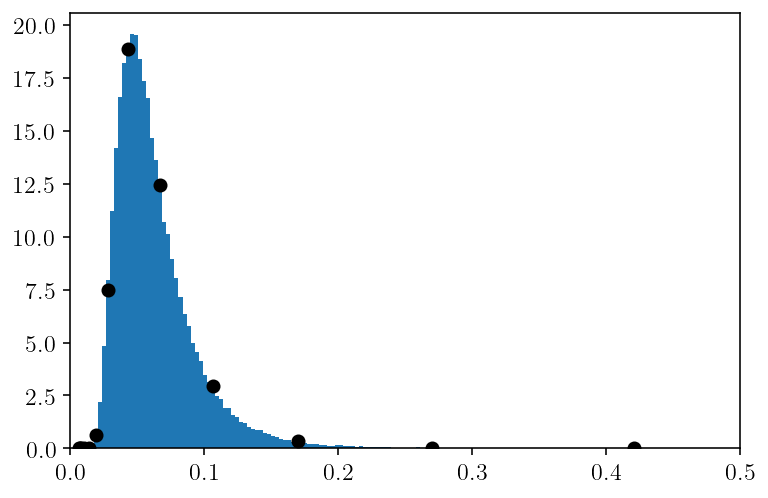

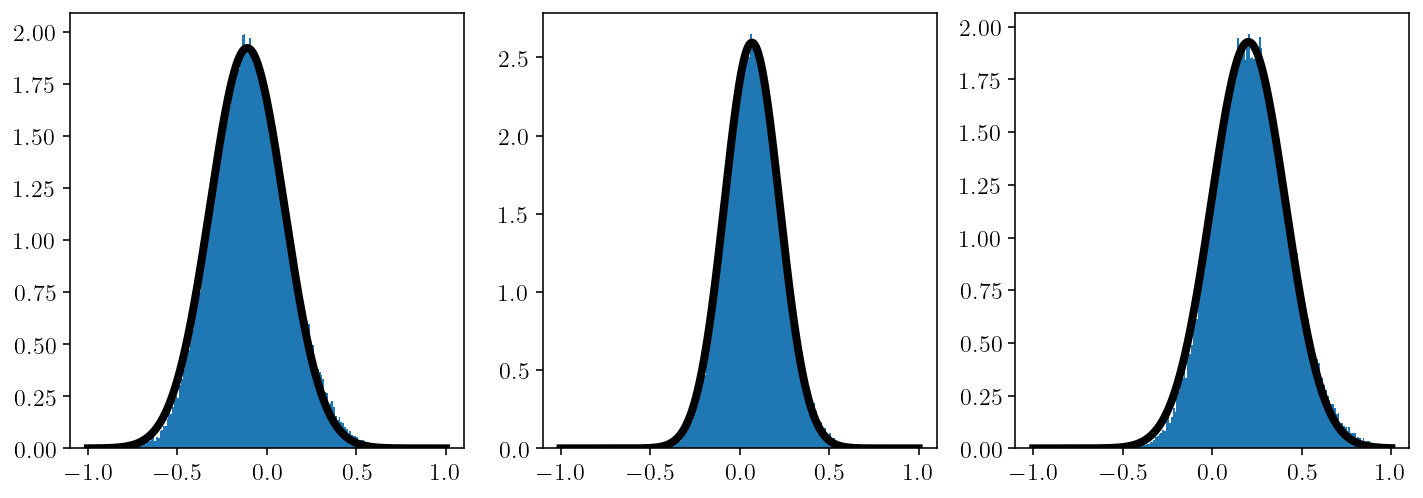

In [233]:
plt.plot(sigma2_rule.pts, sigma2_post, 'ko')
plt.hist(sig2_samples, bins=np.linspace(0, 0.3, 101), density=True)
plt.xlim([0, 0.5])
plt.show()

theta_sigma = np.sqrt(np.diagonal(-np.linalg.inv(hess), axis1=1, axis2=2))
plt.figure(figsize=(12, 4))
plt_vs = np.linspace(-1, 1, 1000)
for j in range(3):
    plt.subplot(1, 3, 1 + j)
    plt.hist(rho_samples_fixed[:, j], density=True, bins=np.linspace(-1.0, 1.0, 201))
    plt.plot(plt_vs, scipy.stats.norm.pdf(plt_vs, theta_max[-1, j], theta_sigma[-1, j]), 'k-', linewidth=4)
plt.show()

In [295]:
@jax.jit
def log_joint(data, rho):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    n_events = data[...,0]
    total_obs_time = data[...,1]
    rho_m0 = rho - mu_0
    hazard = 1.0 / (jnp.exp(rho) * lambdaj[None])
    return (
        0.5 * jnp.einsum("...i,...ij,...j", rho_m0, neg_precQ, rho_m0)
        + logprecQdet
        + jnp.sum(jnp.log(hazard) * n_events[:, None] - hazard * total_obs_time[:, None], axis=-1)
        + log_prior
    )


def scalar_log_joint_opt(rho, neg_precQ, n_events, total_obs_time):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    rho_m0 = rho - mu_0
    hazard = 1.0 / (jnp.exp(rho) * lambdaj)
    return (
        0.5 * neg_precQ.dot(rho_m0).T.dot(rho_m0)
        + jnp.sum(jnp.log(hazard) * n_events - hazard * total_obs_time)
    )
grad_opt = jax.jit(jax.vmap(jax.vmap(jax.grad(scalar_log_joint_opt), in_axes=(0, 0, None, None)), in_axes=(0, None, 0, 0)))
hessian_opt = jax.jit(jax.vmap(jax.vmap(jax.hessian(scalar_log_joint_opt), in_axes=(0, 0, None, None)), in_axes=(0, None, 0, 0)))

def grad_hess(fi, data, rho, arms_opt):
    grad = grad_opt(rho, fi.neg_precQ, data[..., 0], data[..., 1])
    hess = hessian_opt(rho, fi.neg_precQ, data[..., 0], data[..., 1])
    return grad, hess

import berrylib.fast_inla as fast_inla
model = fast_inla.FastINLAModel(lambda fi, *args: log_joint(*args), grad_hess)
fi = fast_inla.FastINLA(
    model = model, 
    n_arms = 3,
    mu_0 = mu_mean,
    mu_sig2 = mu_sig2,
    sigma2_n = 20,
    sigma2_bounds = [0.006401632420120484, 2.8421994410275007],
    sigma2_alpha = sig2_alpha,
    sigma2_beta = sig2_beta
)

In [296]:
%%time
np_inference = fi.numpy_inference(suff_stats, thresh_theta=np.repeat(np.log(1.0), 3))

(5000, 20, 3) (5000, 3, 2) (20, 3, 3)
(5000, 20, 3) (5000, 3, 2) (20, 3, 3)
(5000, 20, 3) (5000, 3, 2) (20, 3, 3)
(5000, 20, 3) (5000, 3, 2) (20, 3, 3)
(5000, 20, 3) (5000, 3, 2) (20, 3, 3)
CPU times: user 4.46 s, sys: 877 ms, total: 5.34 s
Wall time: 2.76 s


In [298]:
2.76 * 1e6 / suff_stats.shape[0]

552.0

In [299]:
np.sum(np.any(np_inference[1] > 0.95, axis=1)) / np_inference[1].shape[0]

0.0886